In [ ]:
import torch
print(torch.version.cuda)

12.1


In [ ]:
!pip install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu121
!pip install "git+https://github.com/facebookresearch/pytorch3d.git"

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121
  Cloning https://github.com/facebookresearch/pytorch3d.git to /tmp/pip-req-build-ei63jy44
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-ei63jy44
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit f34104cf6ebefacd7b7e07955ee7aaa823e616ac
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 924.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch3d: filename=pytorch3d-0.7.6-cp310-cp310-linux_x86_64.whl size=51542785 sha256=30031507c0683d5f1593f3f229b055848cbd85f1f6210c3c0c4ec7e12c0cc649
  Stored in directory: /tmp/pip-ephem-wheel-cache-t4xwxnyf/wheels/dd/74/cc/b9266c863f19026f796e59a04e1cd9eb3754474a52ce1b66c

In [19]:
import torch
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.io import save_obj

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

sphere_mesh = ico_sphere(level=3, device=device)

# Create a simple texture that can be applied to the sphere
# Create a vertex color texture where the color smoothly changes
# from blue at the top to red at the bottom.
verts = sphere_mesh.verts_packed()
colors = torch.full([1, verts.shape[0], 3], 0.5, device=device)
colors[0, :, 2] = torch.linspace(0, 1, steps=verts.shape[0], device=device) # blue channel
colors[0, :, 0] = torch.linspace(1, 0, steps=verts.shape[0], device=device) # red channel
textures = TexturesVertex(verts_features=colors)

# Add textures to the mesh
sphere_mesh.textures = textures

save_obj("sphere.obj", verts=sphere_mesh.verts_packed(), faces=sphere_mesh.faces_packed())


In [20]:
from pytorch3d.renderer import PerspectiveCameras

cameras = PerspectiveCameras(device=device)


In [21]:
from pytorch3d.renderer import RasterizationSettings, MeshRenderer, MeshRasterizer, SoftPhongShader

raster_settings = RasterizationSettings(
    image_size=512,
    blur_radius=0.0,
    faces_per_pixel=1,
)

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
    shader=SoftPhongShader(device=device, cameras=cameras)
)


(-0.5, 511.5, 511.5, -0.5)

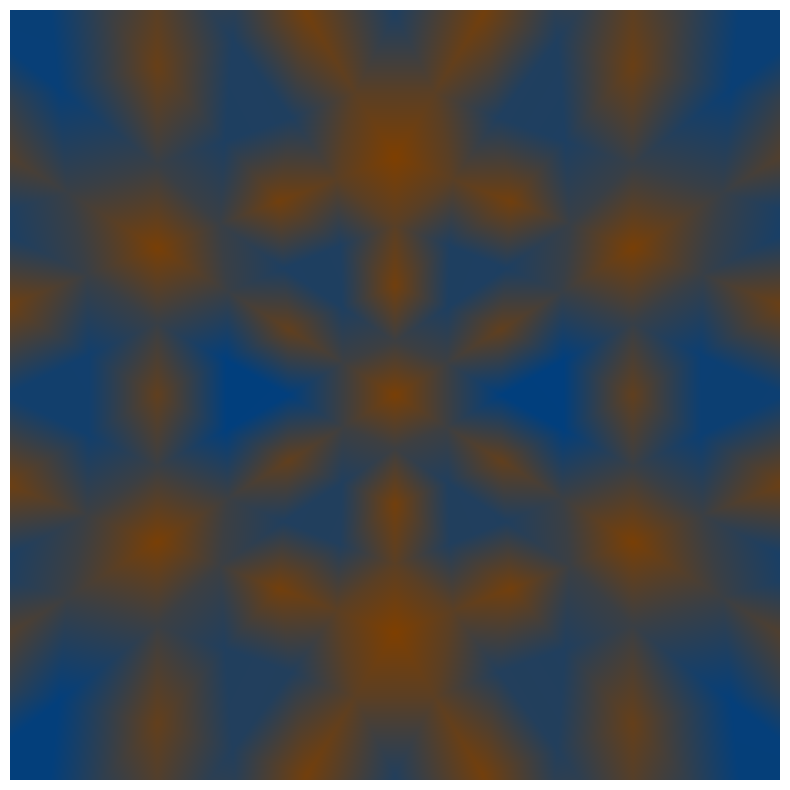

In [23]:
images = renderer(sphere_mesh)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off")
